# Test Toxicity Model Inference

Testing the pre-trained toxicity detection model on 100 threads from BluePrint dataset

In [ ]:
import sys
sys.path.append('./tox_model')

import utils
import torch
import pandas as pd
from datasets import load_dataset
from transformers import pipeline
from tqdm import tqdm


print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS (Mac GPU) available: {torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else False}")

if torch.cuda.is_available():
    device = "cuda"
    device_id = 0
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = "mps"
    device_id = 0  
else:
    device = "cpu"
    device_id = -1  
    
print(f"\nUsing device: {device}")

CUDA available: False
MPS (Mac GPU) available: True

Using device: mps


## 1. Load Toxicity Detection Model

In [ ]:
# Initialize tokenizer
tokenizer = utils.tokenizer_init(
    model_name_or_path="./tox_model/tokenizer",
    truncation_side="left"
)

print("Tokenizer loaded successfully")

Tokenizer loaded successfully


In [11]:
# Initialize model
model = utils.model_init(
    model_name_or_path="./tox_model/checkpoint-110768",
    num_labels=9,
    device=device
)

print(f"Model loaded on: {device}")

Model loaded on: mps


In [12]:
# Create inference pipeline
tox_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",
    device=device_id  # Use device_id determined earlier
)

print("Pipeline created successfully")

Device set to use mps:0


Pipeline created successfully


## 2. Test on Sample Text

In [59]:
# Quick test
test_texts = [
    "Hello, how are you doing today?",
    "This is a normal conversation",
    "You are an idiot and loser",
]

for text in test_texts:
    result = tox_pipeline(text)
    print(f"\nText: {text}")
    print(f"Result: {result}")


Text: Hello, how are you doing today?
Result: [{'entity_group': 'BENIGN', 'score': np.float32(0.9997723), 'word': 'Hello, how are you doing today?', 'start': 0, 'end': 31}]

Text: This is a normal conversation
Result: [{'entity_group': 'BENIGN', 'score': np.float32(0.9956234), 'word': 'This is a normal conversation', 'start': 0, 'end': 29}]

Text: You are an idiot and loser
Result: [{'entity_group': 'Insults', 'score': np.float32(0.8845449), 'word': 'You are an idiot and loser', 'start': 0, 'end': 26}]


## 3. Load BluePrint Dataset (100 threads)

In [55]:
# Load dataset
blueprint = load_dataset("ComplexDataLab/BluePrint", "100_clusters")
ds = blueprint['full']

sample_threads = ds.select(range(100))
print(f"Selected {len(sample_threads)} threads for test inference")

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Selected 100 threads for test inference


## 4. Run Toxicity Inference on 100 Threads

In [56]:
# Function to extract text from thread messages
def extract_texts_from_thread(thread):
    """Extract all text content from a thread"""
    texts = []
    if not isinstance(thread, list):
        return texts
    
    for msg in thread:
        if isinstance(msg, dict) and 'text' in msg:
            text = msg['text']
            if text and isinstance(text, str) and len(text.strip()) > 0:
                texts.append(text)
    
    return texts

# Test on first thread
first_thread = sample_threads[0]['thread']
texts = extract_texts_from_thread(first_thread)
print(f"First thread has {len(texts)} messages with text")
if len(texts) > 0:
    print(f"\nSample message: {texts[0][:200]}...")

First thread has 1 messages with text

Sample message: Guess who's keeping a close eye on Australia's shaky relationship with the US? #France, of course. They quote someone who points out that we may never get our subs from the US.
<URL>...


In [58]:
def analyze_toxicity(text, pipeline):
    """Analyze toxicity of a single text"""
    try:
        result = pipeline(text)
        has_toxicity = any(r['entity_group'] != 'BENIGN' for r in result)
        toxic_spans = [r for r in result if r['entity_group'] != 'BENIGN']
        
        return {
            'is_toxic': has_toxicity,
            'toxic_count': len(toxic_spans),
            'toxic_labels': [r['entity_group'] for r in toxic_spans],
            'toxic_spans': toxic_spans
        }
    except Exception as e:
        print(f"Error analyzing text: {e}")
        

# Test function
test_result = analyze_toxicity("You're a stupid idiot", tox_pipeline)
print("Test result:", test_result)

Test result: {'is_toxic': False, 'toxic_count': 0, 'toxic_labels': [], 'toxic_spans': []}


In [18]:
# Run inference on all 100 threads
print("Running toxicity inference on 100 threads...\n")

results = []

for idx in tqdm(range(len(sample_threads)), desc="Processing threads"):
    thread_data = sample_threads[idx]
    thread = thread_data['thread']
    cluster_id = thread_data['cluster_id']
    
    # Extract texts from thread
    texts = extract_texts_from_thread(thread)
    
    # Analyze each message
    thread_toxicity = []
    for text in texts:
        tox_result = analyze_toxicity(text, tox_pipeline)
        thread_toxicity.append(tox_result)
    
    # Aggregate thread-level statistics
    num_messages = len(texts)
    num_toxic = sum(1 for t in thread_toxicity if t['is_toxic'])
    toxicity_rate = num_toxic / num_messages if num_messages > 0 else 0
    
    # Collect all toxic labels
    all_toxic_labels = []
    for t in thread_toxicity:
        all_toxic_labels.extend(t['toxic_labels'])
    
    results.append({
        'thread_idx': idx,
        'cluster_id': cluster_id,
        'num_messages': num_messages,
        'num_toxic_messages': num_toxic,
        'toxicity_rate': toxicity_rate,
        'toxic_labels': all_toxic_labels,
        'message_analyses': thread_toxicity
    })

print(f"\nCompleted inference on {len(results)} threads!")

Running toxicity inference on 100 threads...



Processing threads: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Completed inference on 100 threads!


## 5. Analyze Results

In [19]:
# Convert to DataFrame for analysis
df_results = pd.DataFrame(results)

print("=" * 60)
print("TOXICITY INFERENCE RESULTS (100 Threads)")
print("=" * 60)

print(f"\nTotal threads analyzed: {len(df_results)}")
print(f"Total messages: {df_results['num_messages'].sum()}")
print(f"Total toxic messages: {df_results['num_toxic_messages'].sum()}")
print(f"\nOverall toxicity rate: {df_results['num_toxic_messages'].sum() / df_results['num_messages'].sum() * 100:.2f}%")

print(f"\nThreads with toxic content: {(df_results['num_toxic_messages'] > 0).sum()}/{len(df_results)}")
print(f"Threads with 0% toxicity: {(df_results['toxicity_rate'] == 0).sum()}")
print(f"Threads with >50% toxicity: {(df_results['toxicity_rate'] > 0.5).sum()}")

print(f"\nToxicity statistics per thread:")
print(df_results['toxicity_rate'].describe())

TOXICITY INFERENCE RESULTS (100 Threads)

Total threads analyzed: 100
Total messages: 106
Total toxic messages: 39

Overall toxicity rate: 36.79%

Threads with toxic content: 38/100
Threads with 0% toxicity: 62
Threads with >50% toxicity: 36

Toxicity statistics per thread:
count    100.000000
mean       0.370000
std        0.480004
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: toxicity_rate, dtype: float64


In [20]:
# Analyze toxic labels distribution
from collections import Counter

all_labels = []
for labels in df_results['toxic_labels']:
    all_labels.extend(labels)

label_counts = Counter(all_labels)

print("\nToxic Label Distribution:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count}")


Toxic Label Distribution:
  Controversial / Potentially Toxic: 84
  Insults: 9
  Hate: 8
  Extremism: 3


In [21]:
# Show top 5 most toxic threads
print("\n" + "="*60)
print("TOP 5 MOST TOXIC THREADS")
print("="*60)

top_toxic = df_results.nlargest(5, 'toxicity_rate')

for _, row in top_toxic.iterrows():
    print(f"\nThread {row['thread_idx']} (Cluster {row['cluster_id']}):")
    print(f"  Messages: {row['num_messages']}")
    print(f"  Toxic messages: {row['num_toxic_messages']}")
    print(f"  Toxicity rate: {row['toxicity_rate']*100:.1f}%")
    print(f"  Toxic labels: {row['toxic_labels']}")


TOP 5 MOST TOXIC THREADS

Thread 22 (Cluster 0):
  Messages: 1
  Toxic messages: 1
  Toxicity rate: 100.0%
  Toxic labels: ['Insults', 'Insults', 'Insults']

Thread 23 (Cluster 0):
  Messages: 1
  Toxic messages: 1
  Toxicity rate: 100.0%
  Toxic labels: ['Insults']

Thread 24 (Cluster 0):
  Messages: 1
  Toxic messages: 1
  Toxicity rate: 100.0%
  Toxic labels: ['Controversial / Potentially Toxic', 'Controversial / Potentially Toxic']

Thread 25 (Cluster 0):
  Messages: 1
  Toxic messages: 1
  Toxicity rate: 100.0%
  Toxic labels: ['Controversial / Potentially Toxic', 'Controversial / Potentially Toxic', 'Controversial / Potentially Toxic', 'Controversial / Potentially Toxic', 'Controversial / Potentially Toxic']

Thread 26 (Cluster 0):
  Messages: 1
  Toxic messages: 1
  Toxicity rate: 100.0%
  Toxic labels: ['Controversial / Potentially Toxic', 'Controversial / Potentially Toxic']


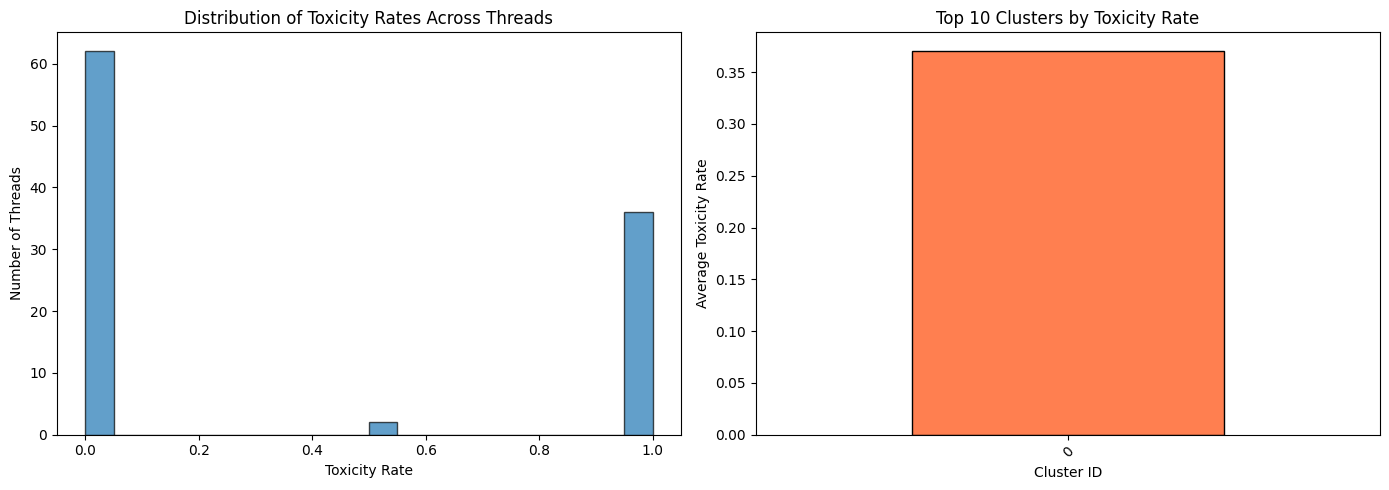

In [22]:
# Visualize toxicity distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of toxicity rates
axes[0].hist(df_results['toxicity_rate'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Toxicity Rate')
axes[0].set_ylabel('Number of Threads')
axes[0].set_title('Distribution of Toxicity Rates Across Threads')

# Toxicity by cluster
cluster_toxicity = df_results.groupby('cluster_id')['toxicity_rate'].mean().sort_values(ascending=False).head(10)
cluster_toxicity.plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Average Toxicity Rate')
axes[1].set_title('Top 10 Clusters by Toxicity Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Save Results

In [ ]:
# Save results to CSV (excluding detailed message analyses)
df_export = df_results[['thread_idx', 'cluster_id', 'num_messages', 'num_toxic_messages', 'toxicity_rate']].copy()
df_export['toxic_label_counts'] = df_results['toxic_labels'].apply(lambda x: dict(Counter(x)))

df_export.to_csv('toxicity_inference_results_100threads.csv', index=False)
print("Results saved to: toxicity_inference_results_100threads.csv")